<img src="../img/logo_amds.png" alt="Logo" style="width: 128px;"/>

# AmsterdamUMCdb - Freely Accessible ICU Database

version 1.0.1 January 2020  
Copyright &copy; 2003-2020 Amsterdam UMC - Amsterdam Medical Data Science

# <a id='freetextitems'></a>freetextitems table
The *freetextitems* table contains all observations, including laboratory results, that store text (non-numeric) data. Personal data, including references to hospital staff have been removed. All items have an associated admissionid from the [admissions](admissions.ipynb#admissions) table.

## Fields

|Name|Type|Description|
|:---|:---|:---|
|admissionid|integer|links the items with the admissionid in the [admissions](admissions.ipynb#admissions) table|
|itemid|integer|id to identify the type of result|
|[item](#item)|string|type of result|
|[value](#value)|string|value of this text result|
|[comment](#comment)|string|comment associated with this result|
|measuredat|integer|time associated with this result in milliseconds since the first admission. Negative results imply that the sample was drawn before the first ICU admission|
|registeredat|integer|time the result was saved to the database in milliseconds since the first admission. Negative results imply that the sample was drawn before the first ICU admission.|
|registeredby|string|user group that updated the result ('System')|
|updatedat|integer|time the result was updated, in milliseconds since the first admission|
|updatedby|string|user group that updated the result ('System')|
|islabresult|bit|determines wheter the observation is a labresult. Currently, only freetext labresults have been released|

<h2>Example Python and SQL scripts</h2>

## Imports

In [1]:
%matplotlib inline
import amsterdamumcdb
import psycopg2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import io
from IPython.display import display, HTML, Markdown

## Display settings

In [2]:
#matplotlib settings for image size
#needs to be in a different cell from %matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.dpi"] = 288
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["font.size"] = 12

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 1000

## Connection settings

In [3]:
#Modify config.ini in the root folder of the repository to change the settings to connect to your postgreSQL database
import configparser
import os
config = configparser.ConfigParser()

if os.path.isfile('../config.ini'):
    config.read('../config.ini')
else:
    config.read('../config.SAMPLE.ini')

#Open a connection to the postgres database:
con = psycopg2.connect(database=config['psycopg2']['database'], 
                       user=config['psycopg2']['username'], password=config['psycopg2']['password'], 
                       host=config['psycopg2']['host'], port=config['psycopg2']['port'])
con.set_client_encoding('WIN1252') #Uses code page for Dutch accented characters.
con.set_session(autocommit=True)

cursor = con.cursor()
cursor.execute('SET SCHEMA \'amsterdamumcdb\''); #set search_path to amsterdamumcdb schema

## Overview of all fields

In [4]:
sql = """
SELECT * FROM freetextitems
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
freetexitems = pd.read_sql(sql,con)
freetexitems.head(10)

``` mysql

SELECT * FROM freetextitems

```

,admissionid,itemid,item,value,comment,measuredat,registeredat,registeredby,updatedat,updatedby,islabresult
0,0,10890,Eiwit Kwal (urine),NEGATIEF,None,-5340000,-5340000,Systeem,62921677,None,1
1,0,10906,Hb/Ery's (urine),SPOOR,None,-5340000,-5340000,Systeem,62921710,None,1
2,0,11646,Afname (bloed),ART.,None,-978000000,-978000000,Systeem,316843,None,1
3,1,10858,Treponema pallidum (ELISA) (bloed),volgt,~ Gecodeerde Aanvr. opm. :Pre-op,-97800000,-97800000,Systeem,14837173,None,1
4,1,10885,Grootte (bloed),ANISO+,None,-79140000,-79140000,Systeem,219220,None,1
5,1,10890,Eiwit Kwal (urine),+,Opmerking verwijderd,-86280000,-86280000,Systeem,236206,None,1
6,1,10891,Gluc.Kwal. (urine),NEGATIEF,Opmerking verwijderd,-86280000,-86280000,Systeem,233096,None,1
7,1,10906,Hb/Ery's (urine),NEGATIEF,Opmerking verwijderd,-86280000,-86280000,Systeem,236706,None,1
8,1,10948,spijt (bloed),volgt,~ Gecodeerde Aanvr. opm. :Pre-op,-97800000,-97800000,Systeem,14838003,None,1
9,1,11646,Afname (bloed),ART.,None,-13500000,-13500000,Systeem,176703,None,1


In [5]:
freetexitems.describe()

,admissionid,itemid,measuredat,registeredat,updatedat
count,662956.000000,662956.000000,6.629560e+05,6.629560e+05,6.629560e+05
mean,11775.007020,11860.369296,5.844029e+09,5.871669e+09,6.477941e+09
std,6769.042966,1176.507421,2.837622e+10,2.843241e+10,2.877191e+10
min,0.000000,10765.000000,-5.172246e+10,-5.172246e+10,-3.061021e+08
25%,6054.000000,11646.000000,9.840000e+06,1.050000e+07,6.084645e+07
50%,11745.000000,11646.000000,2.307600e+08,2.334900e+08,3.665479e+08
75%,17674.000000,11646.000000,1.242435e+09,1.248795e+09,1.468029e+09
max,23551.000000,21207.000000,3.916534e+11,3.916534e+11,3.916539e+11


## <a id='item'></a> item

In [6]:
sql = """
SELECT item, value, comment
FROM freetextitems
WHERE item ILIKE '%coombs%'
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head()

``` mysql

SELECT item, value, comment
FROM freetextitems
WHERE item ILIKE '%coombs%'

```

,item,value,comment
0,Dir.Coombs conclusie (bloed),Poly AHG = negatief,None
1,Dir.Coombs conclusie (bloed),Poly AHG = zwak positief,None
2,Dir.Coombs conclusie (bloed),Poly AHG = negatief,None
3,Dir.Coombs conclusie (bloed),"Poly AHG = Positief, IgG,C3d=positief , IgA,IgM,IgG1,IgG3=negatief",None
4,Dir.Coombs conclusie (bloed),volgt,None


## <a id='value'></a> value

In [7]:
sql = """
SELECT DISTINCT value
FROM freetextitems
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(10)

``` mysql

SELECT DISTINCT value
FROM freetextitems

```

,value
0,50-60
1,dyserythropoïese
2,"Poly AHG = pos, IgG/IgA/IgM en C3c = neg, C3d = sterk Positief"
3,Allo DLI
4,13
5,studie
6,8100
7,0.3
8,182
9,Klasse 0


``` mysql

SELECT item, COUNT(item) AS "Number of results"
FROM freetextitems
WHERE NOT itemid = 11646 -- not a real result: location of bloodsample: arterial, venous, etc.
GROUP BY item
ORDER BY "Number of results" DESC
LIMIT 20

```

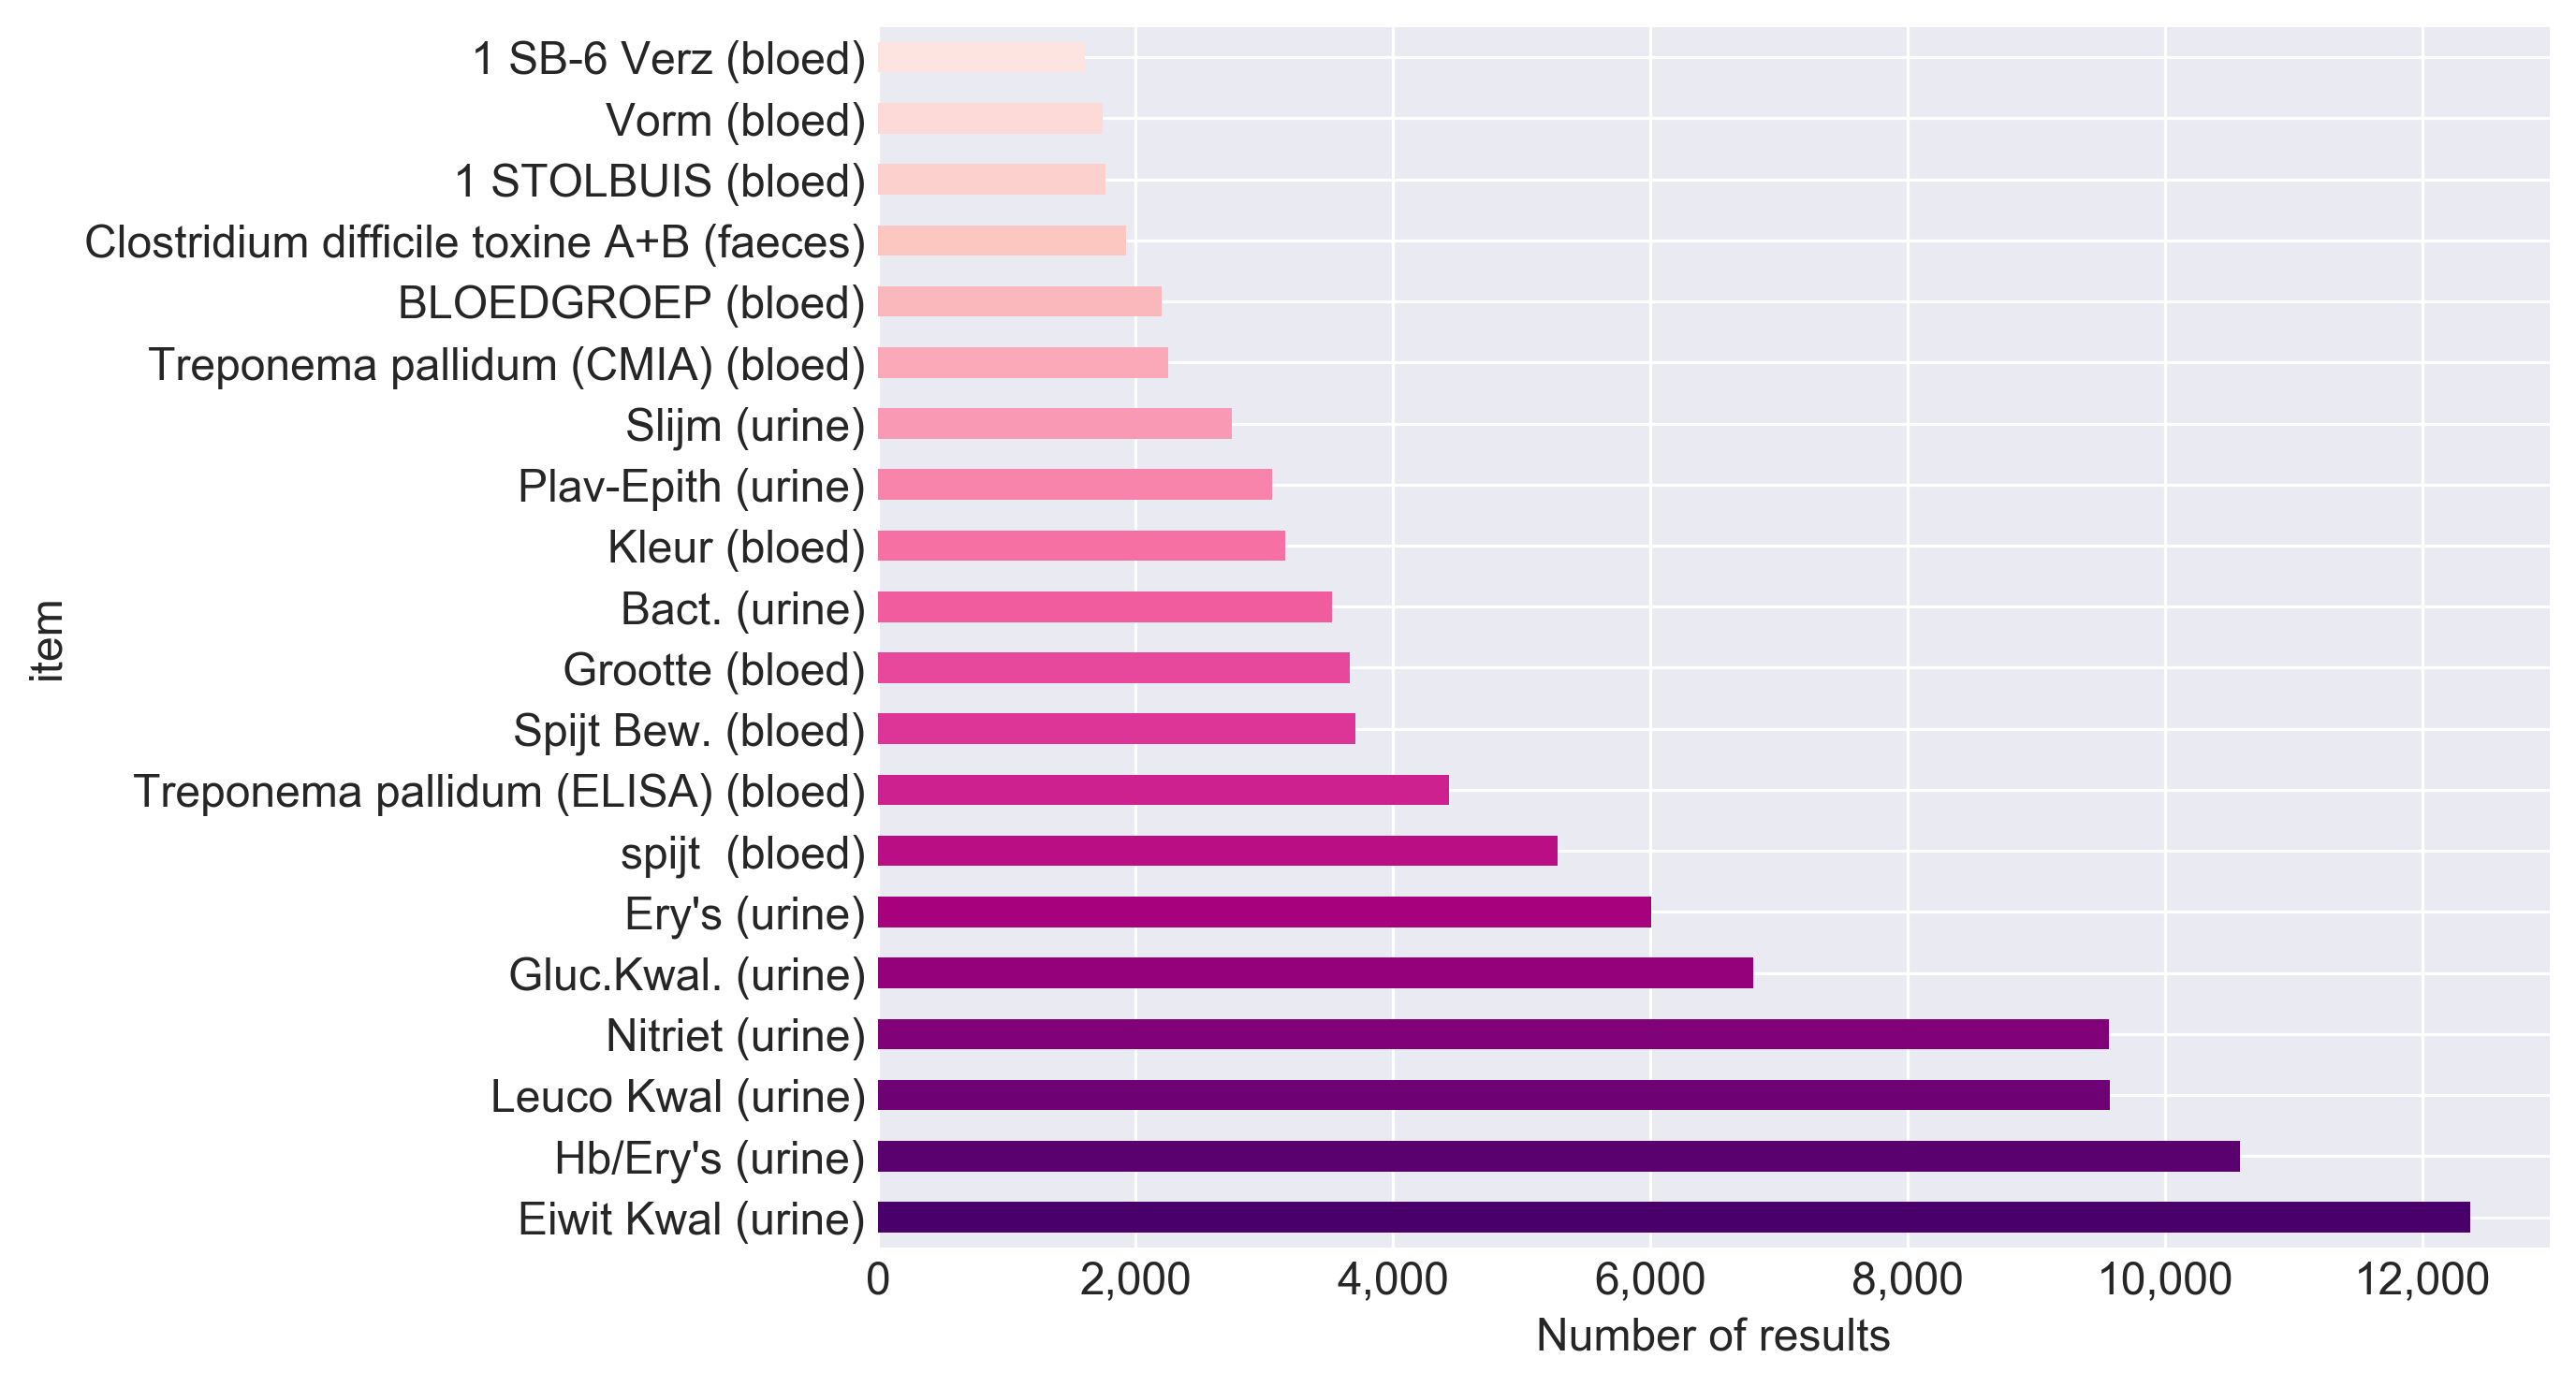

In [8]:
sql = """
SELECT item, COUNT(item) AS "Number of results"
FROM freetextitems
WHERE NOT itemid = 11646 -- not a real result: location of bloodsample: arterial, venous, etc.
GROUP BY item
ORDER BY "Number of results" DESC
LIMIT 20
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.barh(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(xlabel=df.columns[1])
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [9]:
sql = """
SELECT DISTINCT value, COUNT(item) AS "Number of results"
FROM freetextitems
WHERE itemid = 11646 -- location of bloodsample: arterial, venous, etc.
GROUP BY value
ORDER BY "Number of results" DESC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(10)

``` mysql

SELECT DISTINCT value, COUNT(item) AS "Number of results"
FROM freetextitems
WHERE itemid = 11646 -- location of bloodsample: arterial, venous, etc.
GROUP BY value
ORDER BY "Number of results" DESC

```

,value,Number of results
0,ART.,254641
1,Art.,244908
2,Ven.,7457
3,GEM.VEN.,5051
4,Gem. ven.,3560
5,VEN.,3484
6,volgt,2526
7,Vervalt,1531
8,ZIE-OPM,844
9,CAP.,178


``` mysql

SELECT DISTINCT value, COUNT(item) AS "Number of results"
FROM freetextitems
WHERE itemid = 11646 -- location of bloodsample: arterial, venous, etc.
GROUP BY value
ORDER BY "Number of results" DESC
LIMIT 5

```

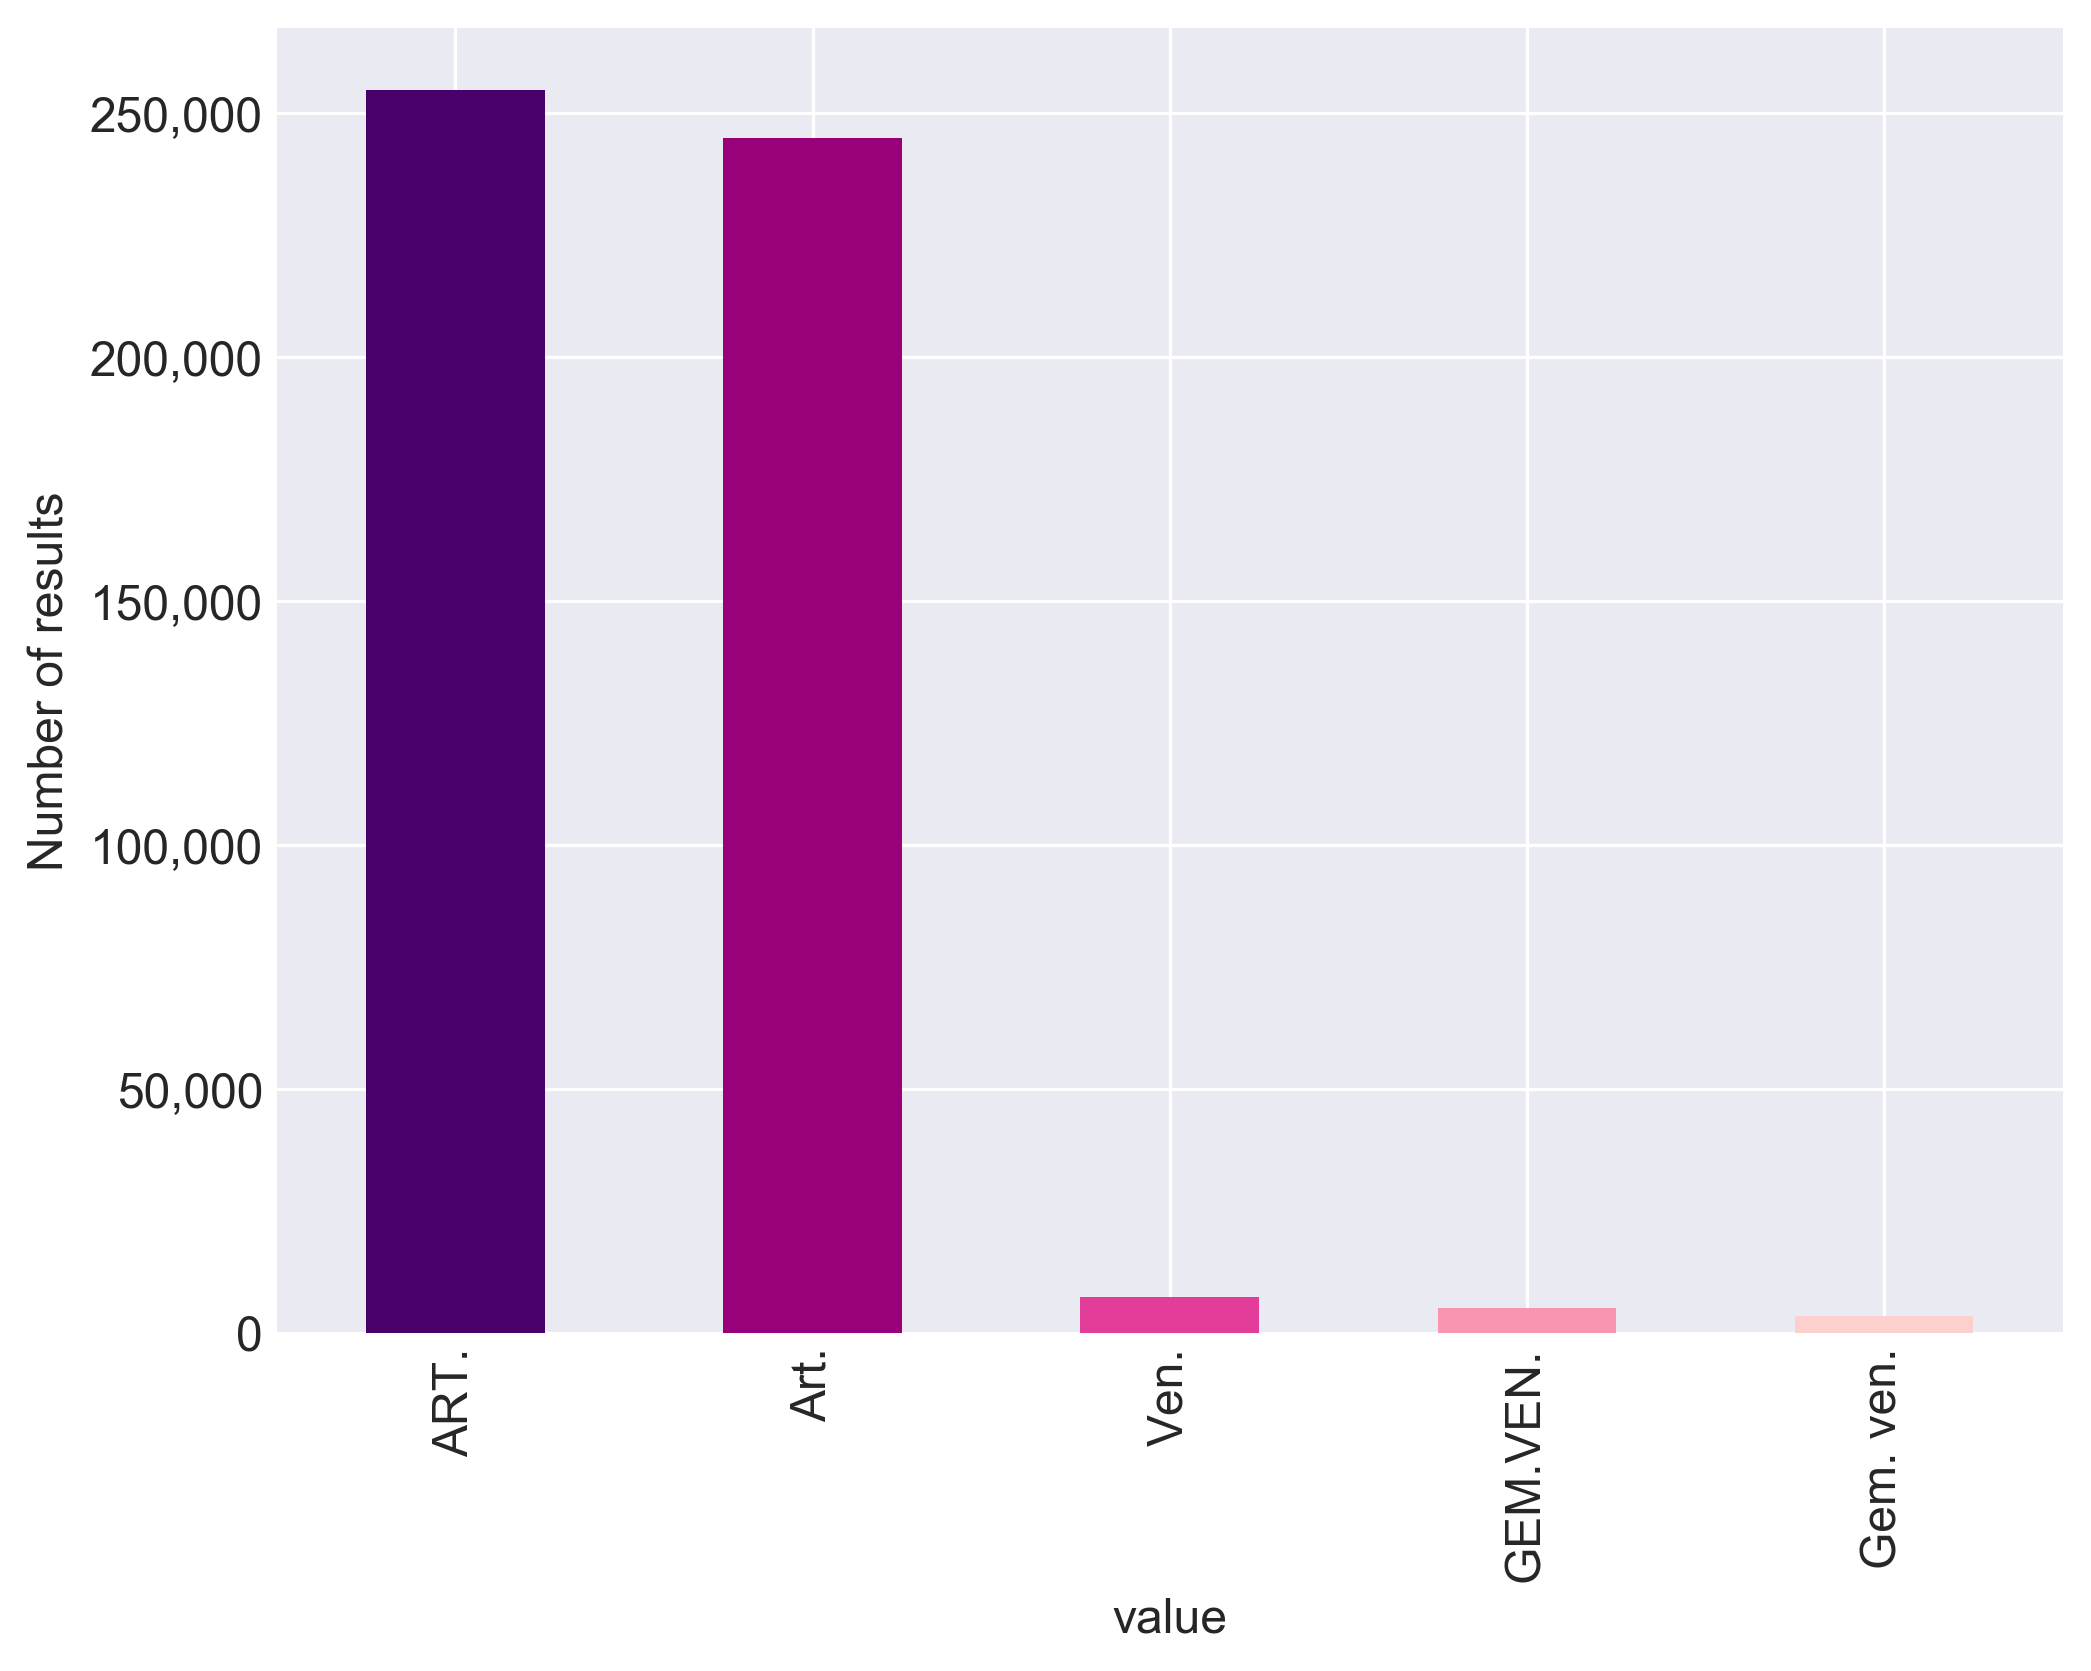

In [10]:
sql = """
SELECT DISTINCT value, COUNT(item) AS "Number of results"
FROM freetextitems
WHERE itemid = 11646 -- location of bloodsample: arterial, venous, etc.
GROUP BY value
ORDER BY "Number of results" DESC
LIMIT 5
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

## <a id='comment'></a> comment

In [11]:
sql = """
SELECT DISTINCT comment
FROM freetextitems
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head()

``` mysql

SELECT DISTINCT comment
FROM freetextitems

```

,comment
0,None
1,VERWISSELING.
2,Geen aanwijzing VWD type I.
3,"AFNAMEFOUT, MONSTER VERVALT."
4,Meest passned bij HCL-variant of SLVL.
